# F20DL Lab 11

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import tensorflow as tf

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(0)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

In [2]:
# Load the dataset into numpy arrays
X = np.load("./datasets/smiley_X_new.npy")
y = np.load("./datasets/smiley_y_new.npy")

In [3]:
# X is a list of all images. Images are represented as columns of pixel values.
# To get pixel (r, c) of image i, use X[i][r-1][c-1][0]

# X[0] returns columns of pixel values representing the 1st image.
# X[0][2][6][0] returns the value of the pixel in the 3rd row and 7th column of the 1st image (r=3, c=7).
# y[0] returns the label for the 1st image. (0 = happy, 1 = sad)

In [4]:
class_names = ["happy", "sad"]

In [5]:
# Shows smiley as an image. 'smiley' should be an element in 'X'
def show_smiley(smiley):
    plt.figure(figsize=(1,1))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(smiley, cmap="Greys")

In [6]:
# Reference: https://stackoverflow.com/a/43957826
def reset_weights(model, weights):
    model.set_weights(weights)

In [7]:
from sklearn.model_selection import KFold

# Perform k-fold cross validation and return scores for each fold
def cross_val(model, model_weights, data, labels, k=10):
    k_fold_splitter = KFold(n_splits=k)
    scores = []
    
    i = 1
    for train_i, test_i in k_fold_splitter.split(data):
        # Select data for current fold
        train_data, train_labels = data[train_i], labels[train_i]
        test_data, test_labels = data[test_i], labels[test_i]
        
        reset_weights(model, model_weights)
        
        print("Training and testing fold %i..." % i)
        
        # Get and save accuracy of current fold
        model.fit(train_data, train_labels, epochs=5, verbose=0)
        acc = model.evaluate(test_data, test_labels, verbose=0)[1]    # Select accuracy only
        scores.append(acc)
        i+=1
    
    return np.asarray(scores)

In [8]:
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, \
    Precision, Recall, AUC

# List of metrics to calculate when evaluating the model
metrics_at_compile = [BinaryAccuracy(), 
                      TruePositives(), 
                      FalsePositives(), 
                      TrueNegatives(), 
                      FalseNegatives(),
                      Precision(), 
                      Recall(), 
                      AUC()]

metric_labels = ["Loss", "Accuracy", "TP", "FP", "TN", "FN", "Sensitivity", "Specificity", "Precision", "Recall", "ROC Area"]
metric_list = []

In [9]:
# Calculate and insert the sensitivity and specificity at indices 6 and 7 respectively
def set_sensitivity_specificity(metrics):
    tp = metrics[2]
    fp = metrics[3]
    tn = metrics[4]
    fn = metrics[5]
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    metrics.insert(6, sensitivity)
    metrics.insert(7, specificity)
    
    return metrics

In [10]:
# Reference: https://stackoverflow.com/a/17568803

# Highlight the best values in the table
def highlight_best_vals(data, table, highlight_color):
    for c in range(data.shape[1]):
        col = data.T[c]
        if c not in [0, 3, 5]:
            best_val_i = np.argwhere(col == np.max(col))    # Indices of highest values
        else:
            best_val_i = np.argwhere(col == np.min(col))    # Indices of lowest values for loss, fp and fn
        
        best_val_i = best_val_i.flatten()
        
        for r in best_val_i:
            table[(r+1, c)].set_facecolor(highlight_color)
            table[(r+1, c)].set_text_props(fontweight="bold")

## Convolutional Neural Networks

### CNN A

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 6384, Testing samples: 2736


In [12]:
cnn0 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn0_weights = cnn0.get_weights()

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [13]:
cnn0.fit(X_train, y_train, epochs=5)

Epoch 1/5
200/200 [==============================] - 18s 50ms/step - loss: 0.3181 - binary_accuracy: 0.8554 - true_positives: 2823.0000 - false_positives: 578.0000 - true_negatives: 2638.0000 - false_negatives: 345.0000 - precision: 0.8300 - recall: 0.8911 - auc: 0.9482
Epoch 2/5
200/200 [==============================] - 6s 30ms/step - loss: 0.1032 - binary_accuracy: 0.9373 - true_positives: 2945.0000 - false_positives: 177.0000 - true_negatives: 3039.0000 - false_negatives: 223.0000 - precision: 0.9433 - recall: 0.9296 - auc: 0.9916
Epoch 3/5
200/200 [==============================] - 6s 30ms/step - loss: 0.0993 - binary_accuracy: 0.9353 - true_positives: 2968.0000 - false_positives: 213.0000 - true_negatives: 3003.0000 - false_negatives: 200.0000 - precision: 0.9330 - recall: 0.9369 - auc: 0.9911
Epoch 4/5
200/200 [==============================] - 6s 28ms/step - loss: 0.0970 - binary_accuracy: 0.9336 - true_positives: 2957.0000 - false_positives: 213.0000 - true_negatives: 3003.000

In [14]:
metrics = cnn0.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])


Test accuracy: 0.9327


In [15]:
y_pred0 = cnn0.predict(X_test)

86/86 [==============================] - 1s 4ms/step


Prediction:  happy


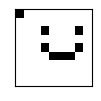

In [16]:
# Prediction for first testing image
print("Prediction: ", class_names[np.argmax(y_pred0[0])])
show_smiley(X_test[0])

In [17]:
# Reference: https://stackoverflow.com/a/43957826
def reset_weights(model, weights):
    model.set_weights(weights)

In [18]:
cross_val_scores = cross_val(cnn0, cnn0_weights, X, y, k=10)
print("Cross validation scores: ", cross_val_scores.round(4))
print("Mean score: ", cross_val_scores.mean().round(4))

Training and testing fold 1...
Training and testing fold 2...
Training and testing fold 3...
Training and testing fold 4...
Training and testing fold 5...
Training and testing fold 6...
Training and testing fold 7...
Training and testing fold 8...
Training and testing fold 9...
Training and testing fold 10...
Cross validation scores:  [0.9298 0.9342 0.932  0.9441 0.9265 0.9287 0.9298 0.9189 0.9189 0.9331]
Mean score:  0.9296


## Experimenting with Different Architectures

### CNN B - Batch Size and Validation Split

#### Batch Size = 100, Validation Split = 0.3

In [19]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.3)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
45/45 [==============================] - 6s 89ms/step - loss: 0.6011 - binary_accuracy: 0.7384 - val_loss: 0.4224 - val_binary_accuracy: 0.8899
Epoch 2/5
45/45 [==============================] - 3s 58ms/step - loss: 0.2639 - binary_accuracy: 0.9116 - val_loss: 0.1514 - val_binary_accuracy: 0.9363
Epoch 3/5
45/45 [==============================] - 2s 54ms/step - loss: 0.1277 - binary_accuracy: 0.9349 - val_loss: 0.1108 - val_binary_accuracy: 0.9327
Epoch 4/5
45/45 [==============================] - 4s 93ms/step - loss: 0.1084 - binary_accuracy: 0.9282 - val_loss: 0.1013 - val_binary_accuracy: 0.9301
Epoch 5/5
45/45 [==============================] - 4s 96ms/step - loss: 0.1047 - binary_accuracy: 0.9306 - val_loss: 0.0953 - val_binary_accuracy: 0.9363

Test accuracy: 0.9262


In [20]:
# Try lower batch size to see if accuracy increases

#### Batch Size = 64, Validation Split = 0.3

In [21]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=64, validation_split=0.3)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
70/70 [==============================] - 5s 42ms/step - loss: 0.5226 - binary_accuracy: 0.7860 - val_loss: 0.2439 - val_binary_accuracy: 0.9217
Epoch 2/5
70/70 [==============================] - 2s 33ms/step - loss: 0.1539 - binary_accuracy: 0.9355 - val_loss: 0.1143 - val_binary_accuracy: 0.9295
Epoch 3/5
70/70 [==============================] - 2s 26ms/step - loss: 0.1070 - binary_accuracy: 0.9353 - val_loss: 0.1018 - val_binary_accuracy: 0.9342
Epoch 4/5
70/70 [==============================] - 2s 33ms/step - loss: 0.1063 - binary_accuracy: 0.9317 - val_loss: 0.1055 - val_binary_accuracy: 0.9295
Epoch 5/5
70/70 [==============================] - 2s 31ms/step - loss: 0.1006 - binary_accuracy: 0.9313 - val_loss: 0.0945 - val_binary_accuracy: 0.9332

Test accuracy: 0.9309


In [22]:
# Accuracy increased. Now try a higher validation split

#### <span style="color:green">*Batch Size = 64, Validation Split = 0.5 - Optimal*</span>

In [23]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics_at_compile])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=64, validation_split=0.5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
50/50 [==============================] - 14s 129ms/step - loss: 0.5967 - binary_accuracy: 0.7904 - true_positives: 1585.0000 - false_positives: 404.0000 - true_negatives: 1659.0000 - false_negatives: 456.0000 - precision: 0.7969 - recall: 0.7766 - auc: 0.8958 - val_loss: 0.4074 - val_binary_accuracy: 0.8897 - val_true_positives: 1299.0000 - val_false_positives: 70.0000 - val_true_negatives: 1541.0000 - val_false_negatives: 282.0000 - val_precision: 0.9489 - val_recall: 0.8216 - val_auc: 0.9570
Epoch 2/5
50/50 [==============================] - 2s 40ms/step - loss: 0.2472 - binary_accuracy: 0.9076 - true_positives: 1374.0000 - false_positives: 82.0000 - true_negatives: 1523.0000 - false_negatives: 213.0000 - precision: 0.9437 - recall: 0.8658 - auc: 0.9767 - val_loss: 0.1564 - val_binary_accuracy: 0.9326 - val_true_positives: 1439.0000 - val_false_positives: 73.0000 - val_true_negatives: 1538.0000 - val_false_negatives: 142.0000 - val_precision: 0.9517 - val_recall: 0.9102 - v

In [24]:
# Accuracy increased slightly. Try batch size 100 again

#### Batch Size = 100, Validation Split = 0.5

In [25]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
cnn0.fit(x=X_train, y=y_train, epochs=5, batch_size=100, validation_split=0.5)

metrics = cnn0.evaluate(X_test,  y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
32/32 [==============================] - 5s 81ms/step - loss: 0.6483 - binary_accuracy: 0.7174 - val_loss: 0.5646 - val_binary_accuracy: 0.8524
Epoch 2/5
32/32 [==============================] - 3s 97ms/step - loss: 0.4085 - binary_accuracy: 0.8844 - val_loss: 0.2532 - val_binary_accuracy: 0.9173
Epoch 3/5
32/32 [==============================] - 2s 58ms/step - loss: 0.1806 - binary_accuracy: 0.9330 - val_loss: 0.1469 - val_binary_accuracy: 0.9320
Epoch 4/5
32/32 [==============================] - 2s 55ms/step - loss: 0.1234 - binary_accuracy: 0.9352 - val_loss: 0.1140 - val_binary_accuracy: 0.9305
Epoch 5/5
32/32 [==============================] - 2s 56ms/step - loss: 0.1075 - binary_accuracy: 0.9339 - val_loss: 0.1067 - val_binary_accuracy: 0.9298

Test accuracy: 0.9327


In [26]:
# Accuracy remains the same. Since the loss is slighly lower in the previous configuration and smaller batch sizes tend to
# be less computationally expensive, the previous configuration is chosen as the optimal one.

---

### CNN C - Learning Rate and Momentum

#### Optimiser = SGD, Learning Rate = 0.001

In [27]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])

cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 7s 28ms/step - loss: 0.6946 - binary_accuracy: 0.4547
Epoch 2/5
200/200 [==============================] - 9s 43ms/step - loss: 0.6938 - binary_accuracy: 0.4673
Epoch 3/5
200/200 [==============================] - 10s 48ms/step - loss: 0.6930 - binary_accuracy: 0.4742
Epoch 4/5
200/200 [==============================] - 10s 48ms/step - loss: 0.6923 - binary_accuracy: 0.4984
Epoch 5/5
200/200 [==============================] - 9s 47ms/step - loss: 0.6916 - binary_accuracy: 0.5384

Test accuracy: 0.5632


In [28]:
# Accuracy is quite low. Since the loss is decreasing very slowly, try higher learning rate and use momentum

#### Optimiser = SGD, Learning Rate = 0.01, Momentum = 0.9

In [29]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 11s 44ms/step - loss: 0.6345 - binary_accuracy: 0.7126
Epoch 2/5
200/200 [==============================] - 9s 47ms/step - loss: 0.2027 - binary_accuracy: 0.9182
Epoch 3/5
200/200 [==============================] - 10s 48ms/step - loss: 0.1108 - binary_accuracy: 0.9339
Epoch 4/5
200/200 [==============================] - 9s 47ms/step - loss: 0.1028 - binary_accuracy: 0.9336
Epoch 5/5
200/200 [==============================] - 9s 47ms/step - loss: 0.1012 - binary_accuracy: 0.9334

Test accuracy: 0.9327


In [30]:
# Accuracy increased significantly. Try even higher learning rate

#### <span style="color:green">*Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.9 - Optimal*</span>

In [31]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), 
             loss="binary_crossentropy", 
             metrics=metrics_at_compile)
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 16s 45ms/step - loss: 0.2276 - binary_accuracy: 0.8876 - true_positives: 4203.0000 - false_positives: 668.0000 - true_negatives: 3892.0000 - false_negatives: 357.0000 - precision: 0.8629 - recall: 0.9217 - auc: 0.9719
Epoch 2/5
200/200 [==============================] - 9s 47ms/step - loss: 0.0932 - binary_accuracy: 0.9380 - true_positives: 2931.0000 - false_positives: 159.0000 - true_negatives: 3057.0000 - false_negatives: 237.0000 - precision: 0.9485 - recall: 0.9252 - auc: 0.9919
Epoch 3/5
200/200 [==============================] - 9s 47ms/step - loss: 0.0925 - binary_accuracy: 0.9359 - true_positives: 3012.0000 - false_positives: 253.0000 - true_negatives: 2963.0000 - false_negatives: 156.0000 - precision: 0.9225 - recall: 0.9508 - auc: 0.9912
Epoch 4/5
200/200 [==============================] - 10s 48ms/step - loss: 0.0928 - binary_accuracy: 0.9345 - true_positives: 2935.0000 - false_positives: 185.0000 - true_negatives: 3031.00

In [32]:
# Accuracy increased again. Try lower momentum

#### Optimiser = SGD, Learning Rate = 0.1, Momentum = 0.5

In [33]:
reset_weights(cnn0, cnn0_weights)

cnn0.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5), 
             loss="binary_crossentropy", 
             metrics=[BinaryAccuracy()])
cnn0.fit(X_train, y_train, epochs=5)

metrics = cnn0.evaluate(X_test, y_test, verbose=0)
metrics = np.asarray(metrics).round(4)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 11s 45ms/step - loss: 0.4053 - binary_accuracy: 0.8080
Epoch 2/5
200/200 [==============================] - 9s 47ms/step - loss: 0.1051 - binary_accuracy: 0.9373
Epoch 3/5
200/200 [==============================] - 9s 47ms/step - loss: 0.0974 - binary_accuracy: 0.9325
Epoch 4/5
200/200 [==============================] - 10s 48ms/step - loss: 0.0954 - binary_accuracy: 0.9297
Epoch 5/5
200/200 [==============================] - 9s 47ms/step - loss: 0.0940 - binary_accuracy: 0.9339

Test accuracy: 0.9353


In [34]:
# Accuracy is the same but the loss is slightly higher. Since higher momentum values helps the neural network converge 
# faster, the previous configuration is chosen as the optimal one.

---

### CNN D - No. of Layers

#### 1 Convolutional Layer, 1 Pooling Layer

In [35]:
cnn1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn1_weights = cnn1.get_weights()

cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 131,649
Trainable params: 131,649
Non-trainable params: 0
________________________________________________

In [36]:
cnn1.fit(X_train, y_train, epochs=5)

metrics = cnn1.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 11s 19ms/step - loss: 0.1736 - binary_accuracy: 0.9390 - true_positives: 4410.0000 - false_positives: 406.0000 - true_negatives: 4154.0000 - false_negatives: 150.0000 - precision: 0.9157 - recall: 0.9671 - auc: 0.9920
Epoch 2/5
200/200 [==============================] - 5s 26ms/step - loss: 0.0067 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216.0000 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/5
200/200 [==============================] - 5s 27ms/step - loss: 0.0017 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216.0000 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
200/200 [==============================] - 5s 26ms/step - loss: 7.6046e-04 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negat

---

### CNN E - Kernel Size

#### Kernel Size = (3, 3), 2 Convolutional Layer, 1 Pooling Layer

In [37]:
cnn2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn2_weights = cnn0.get_weights()

cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

In [38]:
cnn2.fit(X_train, y_train, epochs=5)

metrics = cnn2.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 17s 50ms/step - loss: 0.2510 - binary_accuracy: 0.9195 - true_positives: 4223.0000 - false_positives: 397.0000 - true_negatives: 4163.0000 - false_negatives: 337.0000 - precision: 0.9141 - recall: 0.9261 - auc: 0.9844
Epoch 2/5
200/200 [==============================] - 10s 50ms/step - loss: 0.0049 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216.0000 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 3/5
200/200 [==============================] - 10s 49ms/step - loss: 7.3234e-04 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216.0000 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
200/200 [==============================] - 10s 48ms/step - loss: 2.8730e-04 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - tru

---

### CNN F - Stride Length

#### Stride Length = (2, 2), 2 Convolutional Layer, 1 Pooling Layer

In [39]:
cnn3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (2,2), strides=(2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (2,2), strides=(2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn3_weights = cnn0.get_weights()

cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 64)          16448     
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

In [40]:
cnn3.fit(X_train, y_train, epochs=5)

metrics = cnn3.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 13s 27ms/step - loss: 0.3582 - binary_accuracy: 0.8826 - true_positives: 4137.0000 - false_positives: 648.0000 - true_negatives: 3912.0000 - false_negatives: 423.0000 - precision: 0.8646 - recall: 0.9072 - auc: 0.9649
Epoch 2/5
200/200 [==============================] - 5s 27ms/step - loss: 0.0526 - binary_accuracy: 0.9881 - true_positives: 3131.0000 - false_positives: 39.0000 - true_negatives: 3177.0000 - false_negatives: 37.0000 - precision: 0.9877 - recall: 0.9883 - auc: 0.9993
Epoch 3/5
200/200 [==============================] - 5s 27ms/step - loss: 0.0046 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216.0000 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 4/5
200/200 [==============================] - 6s 29ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - true_positives: 3168.0000 - false_positives: 0.0000e+00 - true_negatives: 3216

---

### CNN G - No. of Receptive Filters

#### 8 Receptive Filters

In [41]:
cnn4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(9, 9, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn4_weights = cnn0.get_weights()

cnn4.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_at_compile)
cnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 8, 8, 8)           40        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 8)           264       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 8)          0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 8)                

In [42]:
cnn4.fit(X_train, y_train, epochs=5)

metrics = cnn4.evaluate(X_test,  y_test, verbose=0)
metrics = set_sensitivity_specificity(metrics)
metrics = np.asarray(metrics).round(4)
metric_list.append(metrics)
print('\nTest accuracy:', metrics[1])

Epoch 1/5
200/200 [==============================] - 31s 120ms/step - loss: 0.6292 - binary_accuracy: 0.7998 - true_positives: 3973.0000 - false_positives: 1239.0000 - true_negatives: 3321.0000 - false_negatives: 587.0000 - precision: 0.7623 - recall: 0.8713 - auc: 0.9082
Epoch 2/5
200/200 [==============================] - 21s 104ms/step - loss: 0.3564 - binary_accuracy: 0.8659 - true_positives: 2603.0000 - false_positives: 291.0000 - true_negatives: 2925.0000 - false_negatives: 565.0000 - precision: 0.8994 - recall: 0.8217 - auc: 0.9515
Epoch 3/5
200/200 [==============================] - 21s 107ms/step - loss: 0.2179 - binary_accuracy: 0.8988 - true_positives: 2716.0000 - false_positives: 194.0000 - true_negatives: 3022.0000 - false_negatives: 452.0000 - precision: 0.9333 - recall: 0.8573 - auc: 0.9727
Epoch 4/5
200/200 [==============================] - 17s 85ms/step - loss: 0.1758 - binary_accuracy: 0.9065 - true_positives: 2673.0000 - false_positives: 102.0000 - true_negatives: 3

## Summary

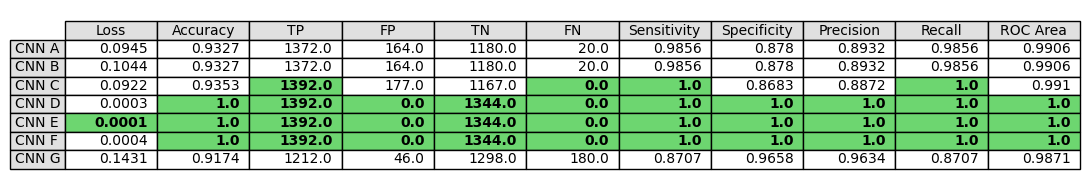


CNN A:- Tutorial CNN
CNN B:- Batch Size = 64, Validation Split = 0.5
CNN C:- Learning Rate = 0.1, Momentum = 0.9
CNN D:- 1 Convolutional Layer, 1 Pooling Layer
CNN E:- Kernel Size = (3, 3), 2 Convolutional Layers, 1 Pooling Layer
CNN F:- Stride Length = (2, 2), 2 Convolutional Layers, 1 Pooling Layer
CNN G:- 8 Receptive Filters



In [43]:
metric_list = np.asarray(metric_list)

fig, ax = plt.subplots(figsize=(11, 2))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

row_labels = ["CNN A", "CNN B", "CNN C", "CNN D", "CNN E", "CNN F", "CNN G"]
col_colors = ["#E0E0E0"] * len(metric_labels)
row_colors = ["#E0E0E0"] * len(row_labels)

table = ax.table(metric_list, 
                 colLabels=metric_labels, 
                 rowLabels=row_labels, 
                 colColours=col_colors, 
                 rowColours=row_colors, 
                 loc="center")

highlight_color = "#6DD670"
highlight_best_vals(metric_list, table, highlight_color)

table.auto_set_font_size(False)

fig.tight_layout()

plt.show()


print("""
CNN A:- Tutorial CNN
CNN B:- Batch Size = 64, Validation Split = 0.5
CNN C:- Learning Rate = 0.1, Momentum = 0.9
CNN D:- 1 Convolutional Layer, 1 Pooling Layer
CNN E:- Kernel Size = (3, 3), 2 Convolutional Layers, 1 Pooling Layer
CNN F:- Stride Length = (2, 2), 2 Convolutional Layers, 1 Pooling Layer
CNN G:- 8 Receptive Filters
""")

In [44]:
# CNN E is the best performing architecture (of those tested) as it has the best values for all metrics. 